In [2]:
import warnings
warnings.filterwarnings("ignore")
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import jax



starry.config.quiet = True
np.random.seed(1)

AttributeError: partially initialized module 'jax' has no attribute 'version' (most likely due to a circular import)

## Helper functions

In [2]:
def Inclination(name, testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        initval=testval,
    )


def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)


# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [3]:
def generate(t, params, seed=1, error=1e-3, visualize=True):
    """
    Generate a synthetic light curve.
    
    """
    # Set up the system
    map = starry.Map(15, 2)
    map.inc = params["star.inc"]["truth"]
    map[1] = params["star.u1"]["truth"]
    map[2] = params["star.u2"]["truth"]
    star = starry.Primary(map, m=params["star.m"]["truth"]) # *** maybe also `r`
    planet = starry.Secondary(
        starry.Map(),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        w=params["planet.w"]["truth"],
        porb=params["planet.porb"]["truth"],
        t0=params["planet.t0"]["truth"],
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    
    # Get the flux design matrix
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    A = map.design_matrix(
        theta=theta, xo=xo, yo=yo, zo=zo, ro=params["planet.r"]["truth"]
    ).eval()
    print(A.shape)
    
    # *** Draw 1 sample from the GP
    np.random.seed(seed)
    sp = StarryProcess(
        mu=params["gp.mu"]["truth"],
        sigma=params["gp.sigma"]["truth"],
        r=params["gp.r"]["truth"],
        c=params["gp.c"]["truth"],
        n=params["gp.n"]["truth"],
    )
    y = sp.sample_ylm().eval().reshape(-1)

    # Starry process Ylms are normalized so that they have
    # zero luminosity (i.e., a featureless star has Y_{0,0} = 0)
    # Let's renormalize it to unity, since that's the baseline
    # we want for transits
    y[0] += 1
    
    # Compute the light curve
    flux0 = A @ y


    mu_ylm = sp.mean_ylm
    mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
    mu_flux = tt.dot(A, mu_ylm)
    
    # Add photometric noise
    err = np.ones_like(flux0) * error
    flux = np.array(flux0)
    noise = np.random.randn(len(t)) * err
    flux += noise
    
    # *** Normalize the flux
    med_flux = np.median(flux)
    flux /= med_flux
    err /= med_flux
    
    # Visualize the system
    if visualize:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
        ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
        ax[0].set_aspect(1)
        ax[0].axis("off")
        map[:, :] = y
        map.show(ax=ax[0])
        ax[0].set_ylim(-3, 3)
        idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
        lat = 180 / np.pi * np.arcsin(yo[idx])
        lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
        lon = (lon + 180) % 360 - 180
        mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
        mask[mask == 1] = np.nan
        map.show(ax=ax[1], projection="rect")
        ax[1].plot(lon, lat + mask, "k-");
    
    return flux, err, med_flux, mu_flux

Based on Hogg's notes: https://ui.adsabs.harvard.edu/abs/2020arXiv200514199H/abstract,
I have $$ln L_m = -\frac{1}{2} r_m^T \Sigma^{-1} r_m - \frac{1}{2}ln\vert\Sigma\vert - \frac{K}{2} ln(2\pi)$$
$$r_m = f_m - \mu$$
from eq. (19) and (20):
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s\vert  \vert\Sigma_s^{-1}\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert $$
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
$$ln \vert\Sigma\vert = ln \vert\Sigma_d\vert + ln \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
from eq. (24):
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (\Sigma_s^{-1}+A^T\Sigma_d^{-1}A)^{-1}A^T\Sigma_d^{-1}$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (I+\Sigma_s A^T\Sigma_d^{-1}A)^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$U = I+\Sigma_s A^T\Sigma_d^{-1}A$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A U^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$Q = r_m^T \Sigma^{-1} r_m = r_m^T(\Sigma_d^{-1} - \Sigma_d^{-1} A \Sigma_s U^{-1}A^T\Sigma_d^{-1})r_m$$
$$v = A^T\Sigma_d^{-1}r_m = A^T r_m/\sigma^2$$
$$v^T = r_m^T\Sigma_d^{-1}A$$
$$Q = r_m^T\Sigma_d^{-1}r_m - v^T \Sigma_s U^{-1}v$$

In [4]:
def bin_out_of_transit(t, flux, err, params, dt=0.1, binsize=30):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

some linear algebra:
$$\Sigma_d^{-1}r_m = r_m\frac{1}{\sigma^2}$$
$$r_m^T\Sigma_d^{-1} = (r_m\frac{1}{\sigma^2})^T$$
$$r_m^T\Sigma_d^{-1}r_m = r_m^2/\sigma^2$$

Solving for mean and covariance of $f_{obs}$
$$m=1/\alpha$$
$$f_{obs} = f_{true}{\alpha}+\epsilon$$
$$f_{true} \sim \mathcal{N}(\mu,\Sigma)$$
$$\epsilon \sim \mathcal{N}(0,\sigma^2 I)$$
$$f_{obs} \sim \mathcal{N}(\frac{\mu}{m},\frac{\Sigma}{m^2}+\sigma^2I)$$
Now, I need to change $\Sigma$:
$$\tilde\Sigma^{-1} = (\frac{1}{m^2}\Sigma)^{-1} = m^2\Sigma^{-1}$$
$$\tilde Q = m^2 Q$$
$$ln\vert\tilde\Sigma\vert = ln\vert\frac{1}{m^2}\Sigma\vert = ln((\frac{1}{m^2})^n\vert\Sigma\vert) = -2n ln(m)+ ln\vert\Sigma\vert$$

In [5]:
def gp_model(t, flux, err, params):

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        # Instantiate the system
        map = starry.Map(15, 2)
        map.inc = parameter("star.inc")
        map[1] = parameter("star.u1")
        map[2] = parameter("star.u2")
        star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
        planet = starry.Secondary(
            starry.Map(),
            inc=parameter("planet.inc"),
            ecc=parameter("planet.ecc"),
            Omega=parameter("planet.Omega"),
            w=parameter("planet.w"),
            porb=parameter("planet.porb"),
            t0=parameter("planet.t0"),
        )
        sys = starry.System(star, planet)
        xo, yo, zo = sys.position(t)

        # Get the flux design matrix
        theta = (360 * t / parameter("star.prot")) % 360
        A = map.design_matrix(
            theta=theta,
            xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
            yo=yo[1],
            zo=zo[1],
            ro=parameter("planet.r"),
        )

        # Instantiate the GP
        # sigma = pm.Uniform("sigma", 1.0, 10.0)
        sp = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            # sigma=sigma,
            r=parameter("gp.r"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            marginalize_over_inclination=False,  # *** we know the inclination
            normalized=False,  # *** we're modeling the normalization explicitly
        )
        norm = parameter("gp.norm")
        
        A = A / norm
        
        '''
        # Compute the flux covariance
        cov_ylm = sp.cov_ylm
        cov_flux = tt.dot(tt.dot(A, cov_ylm), tt.transpose(A)) / norm ** 2
        cov_flux += tt.diag(err) ** 2

        # Compute the flux mean; remember to offset Y_{0,0} by one
        mu_ylm = sp.mean_ylm
        mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
        mu_flux = tt.dot(A, mu_ylm) / norm

        # Marginal likelihood
        pm.MvNormal("marginal", mu=mu_flux, cov=cov_flux, observed=flux)
        '''
        Sigma_s = sp.cov_ylm 
        mu_ylm = sp.mean_ylm
        mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
        mu_flux = tt.dot(A, mu_ylm) #/ norm
        K = len(t)

        U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[:,None])))

        log_sigmadet = 2*tt.sum(tt.log(err)) + pmm.logdet(U) 
        # log_sigmadet -= 2*256*tt.log(norm)

        r = tt.as_tensor_variable(flux) - mu_flux
        v = tt.dot(A.T,(r/tt.square(err)))
        Q = tt.sum(tt.square(r/err)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))

        loglike = -0.5 * Q
        loglike -= 0.5  * log_sigmadet
        loglike -= 0.5 * K * tt.log(2 * np.pi)

        pm.Potential("lnlike", loglike)

        
        return model

## Generate a light curve

(721, 256)


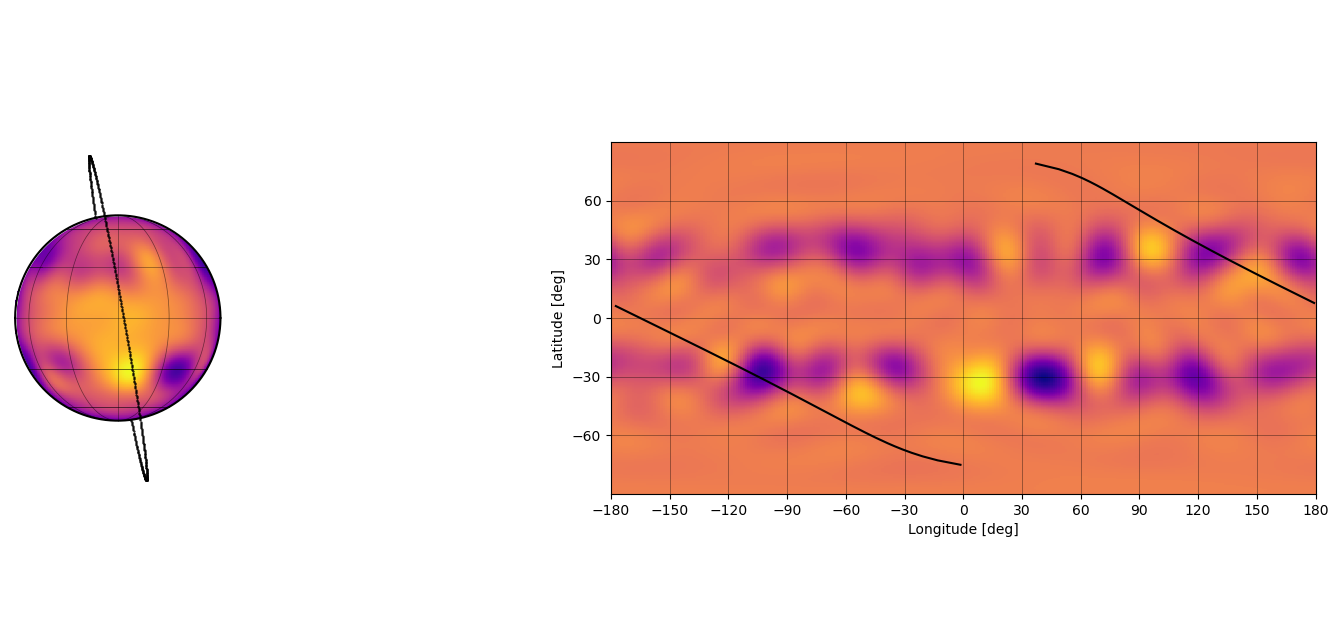

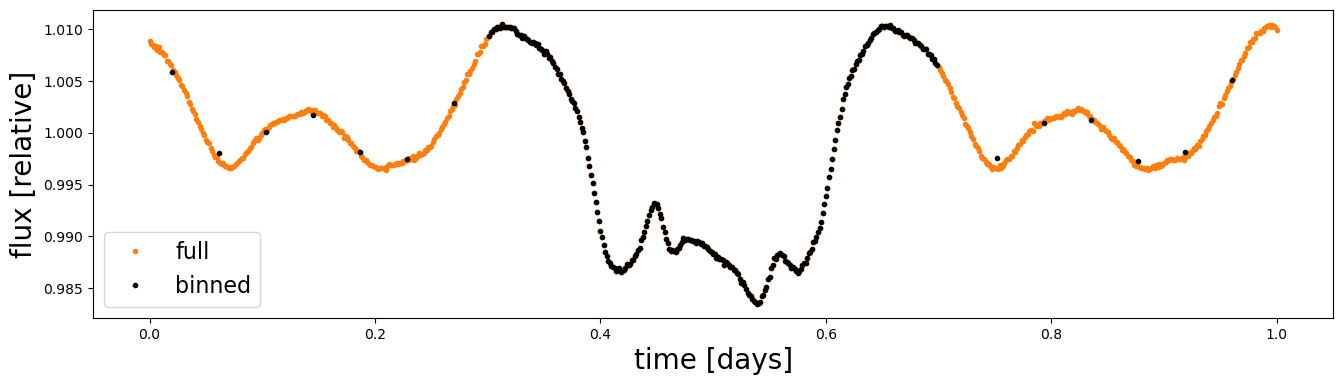

In [6]:
# *** True parameters & priors
params = {
    "planet.inc": {"truth": 88.0, "dist": Inclination},
    "planet.ecc": {"truth": 0.0, "dist": Uniform, "args": [0.0, 0.4]},
    "planet.Omega": {"truth": 100, "dist": Angle},
    "planet.w": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 1.0, "dist": Uniform, "args": [0.975, 1.025]},
    "planet.t0": {"truth": 0.5, "dist": Uniform, "args": [0.475, 0.525]},
    "planet.r": {"truth": 0.1, "dist": Uniform, "args": [0.06, 0.14]},
    "star.inc": {"truth": 90, "dist": Inclination},
    "star.m": {"truth": 0.5, "dist": Uniform, "args": [0.4, 0.6]},
    "star.u1": {"truth": 0.4, "dist": Uniform, "args": [0.0, 0.6]},
    "star.u2": {"truth": 0.2, "dist": Uniform, "args": [0.0, 0.4]},
    "star.prot": {"truth": 0.34, "dist": pm.Uniform, "args": [0.1, 1.0]},
    "gp.r": {"truth": 10, "dist": Uniform, "args": [5.0, 25.0]},
    "gp.c": {"truth": 0.1, "dist": Uniform, "args": [0.01, 0.5]},
    "gp.n": {"truth": 20, "dist": Uniform, "args": [1, 30]},
    "gp.mu": {"truth": 30, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 5, "dist": Uniform, "args": [1.0, 10]},
    "gp.norm": {"truth": 1, "dist": Uniform, "args": [0.8, 1.2]}
}

# *** Time array (1 day @ 2 min cadence)
t = np.arange(0, 1, 2 / 24 / 60)

# Get the light curve
flux, err, med_flux, mu_flux = generate(t, params, error=1e-4)

# Get the binned light curve
t_, flux_, err_ = bin_out_of_transit(t, flux, err, params, dt=0.2)

# Plot the data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux, "C1.", alpha=1, label="full")
ax.plot(t_, flux_, "k.", label="binned")
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

In [7]:
params['gp.norm']['truth'] = med_flux

# Inference

In [8]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.sigma"]["free"] = True
p["gp.n"]["free"] = True
p["gp.c"]["free"] = True
p["gp.r"]["free"] = True
p["gp.norm"]["free"] = True
free = [x for x in p.keys() if p[x].get("free", False)]
model = gp_model(t, flux, err, p)

In [9]:
from starry_process import MCMCInterface

with model:
    mci = MCMCInterface()

In [10]:
x = mci.optimize()
print(mci.transform(x, varnames=free))

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]


message: Desired error not necessarily achieved due to precision loss.
logp: 5445.607599558083 -> 5447.709593147595


100%|██████████| 1/1 [00:00<00:00, 16.33it/s]

[10.49368317  0.08643861 19.14147692 28.58311539  3.74366705  0.95012988]


In [11]:
nwalkers = 15
p0 = mci.get_initial_state(nwalkers)

In [12]:
mci.logp(x)

array(5447.70750153)

# Sampling
Will's sampling technique:

1. Run for nsteps = 100 steps; look at the $<lnprob>$ over the ensemble at each step; reset.
2. nsteps = 100; look at the autocorrelation estimate. 

In [13]:
import emcee

# Number of parameters
ndim = p0.shape[1]

# Instantiate the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp)

# Run the chains
np.random.seed(0)
nsteps = 1000
state = sampler.run_mcmc(p0, nsteps, progress=True, store=True)

100%|██████████| 1000/1000 [18:12<00:00,  1.09s/it]


In [37]:
max_n = 1000
n_inc = 1

# We'll track how the average autocorrelation time estimate changes
index = 0
ave_logp = np.empty(max_n)

# Now we'll sample for up to max_n steps
for sample in sampler.sample(p0, iterations=max_n, progress=True):
    # Only check convergence every n_inc steps
    if sampler.iteration % n_inc:
        continue
    
    L = sampler.get_log_prob()
    ave_logp[index] = np.mean(L)
    index += 1

100%|██████████| 1000/1000 [17:39<00:00,  1.06s/it]


In [38]:
index

1000

Text(0, 0.5, 'mean logp')

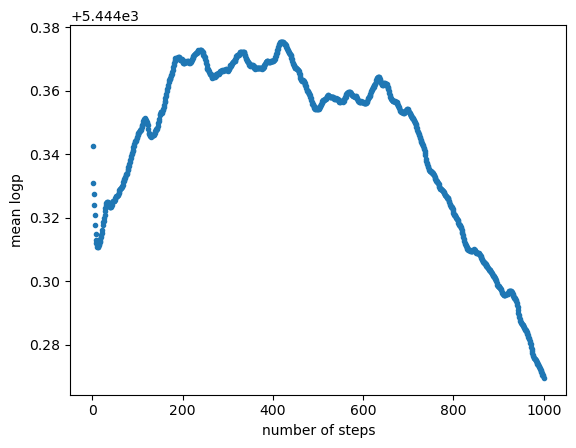

In [39]:
n = np.arange(1, index + 1)
y = ave_logp[:index]
plt.plot(n, y, '.')
plt.xlabel("number of steps")
plt.ylabel('mean logp')

In [28]:
import arviz as az
az.summary(sampler)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
var_0,-0.507,0.032,-0.566,-0.446,0.004,0.003,65.0,219.0,1.17
var_1,0.579,0.782,-0.647,2.168,0.146,0.104,28.0,29.0,1.52
var_2,-1.547,0.301,-2.037,-0.914,0.054,0.039,33.0,40.0,1.39
var_3,-1.059,0.202,-1.459,-0.740,0.027,0.019,62.0,142.0,1.19
var_4,-0.387,0.803,-1.854,1.112,0.111,0.079,50.0,144.0,1.23
var_5,-0.560,0.097,-0.738,-0.379,0.012,0.009,59.0,307.0,1.19


In [40]:
def run_sampler_to_convergence(sampler, xs, nsamp):
    while True:
        sampler.reset()
        sampler.run_mcmc(xs, int(round(nsamp/2)), progress=True)
        xs = sampler.chain[:,-1,:]
        mean_lnprobs = np.mean(sampler.lnprobability, axis=0)

        if mean_lnprobs[-1] < mean_lnprobs[0]:
            break

    # Burned in, at least in the likelihood
    nfac = 1
    while True:
        xs = sampler.chain[:,-1,:]
        sampler.reset()
        sampler.run_mcmc(xs, nsamp, progress=True, thin_by=nfac)

        ac = sampler.get_autocorr_time(quiet=True)

        ac = np.max(ac)

        Nact = nsamp / ac

        if Nact > 50:
            break
        nfac *= 2

    return sampler

In [41]:
sampler.reset()

In [42]:
sampler_new = run_sampler_to_convergence(sampler, p0, nsteps)

100%|██████████| 1000/1000 [16:21<00:00,  1.02it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [82.49949073 68.37254064 86.82663249 52.42922028 66.51281154 71.31150667]
100%|██████████| 2000/2000 [34:12<00:00,  1.03s/it]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [53.5529909  87.14271969 70.60879494 68.86749728 49.59359915 53.46295756]
100%|██████████| 4000/4000 [1:08:26<00:00,  1.03s/it]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [44.59698395 81.98283862 63.00915929 36.34140696 38.59927126 33.57857553]
100%|██████████| 8000/8000 [2:15:56<00:00,  1.02s/it]  
The chain is shorter than 50 times the integrated autocorrelation time for 6 p

In [43]:
import arviz as az
az.summary(sampler_new)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
var_0,-0.504,0.033,-0.566,-0.440,0.001,0.000,3036.0,7866.0,1.00
var_1,1.102,1.185,-0.804,3.467,0.042,0.029,796.0,1175.0,1.01
var_2,-1.631,0.308,-2.152,-1.048,0.010,0.007,1069.0,1608.0,1.01
var_3,-1.127,0.223,-1.538,-0.759,0.004,0.003,2474.0,3744.0,1.00
var_4,-0.273,0.661,-1.477,0.985,0.012,0.008,3096.0,3459.0,1.00
var_5,-0.546,0.098,-0.726,-0.361,0.001,0.001,4213.0,8874.0,1.00


In [44]:
samples = sampler.chain.reshape(-1, ndim)

In [45]:
samples = mci.transform(samples, varnames=free)

100%|██████████| 15000/15000 [10:36<00:00, 23.56it/s]


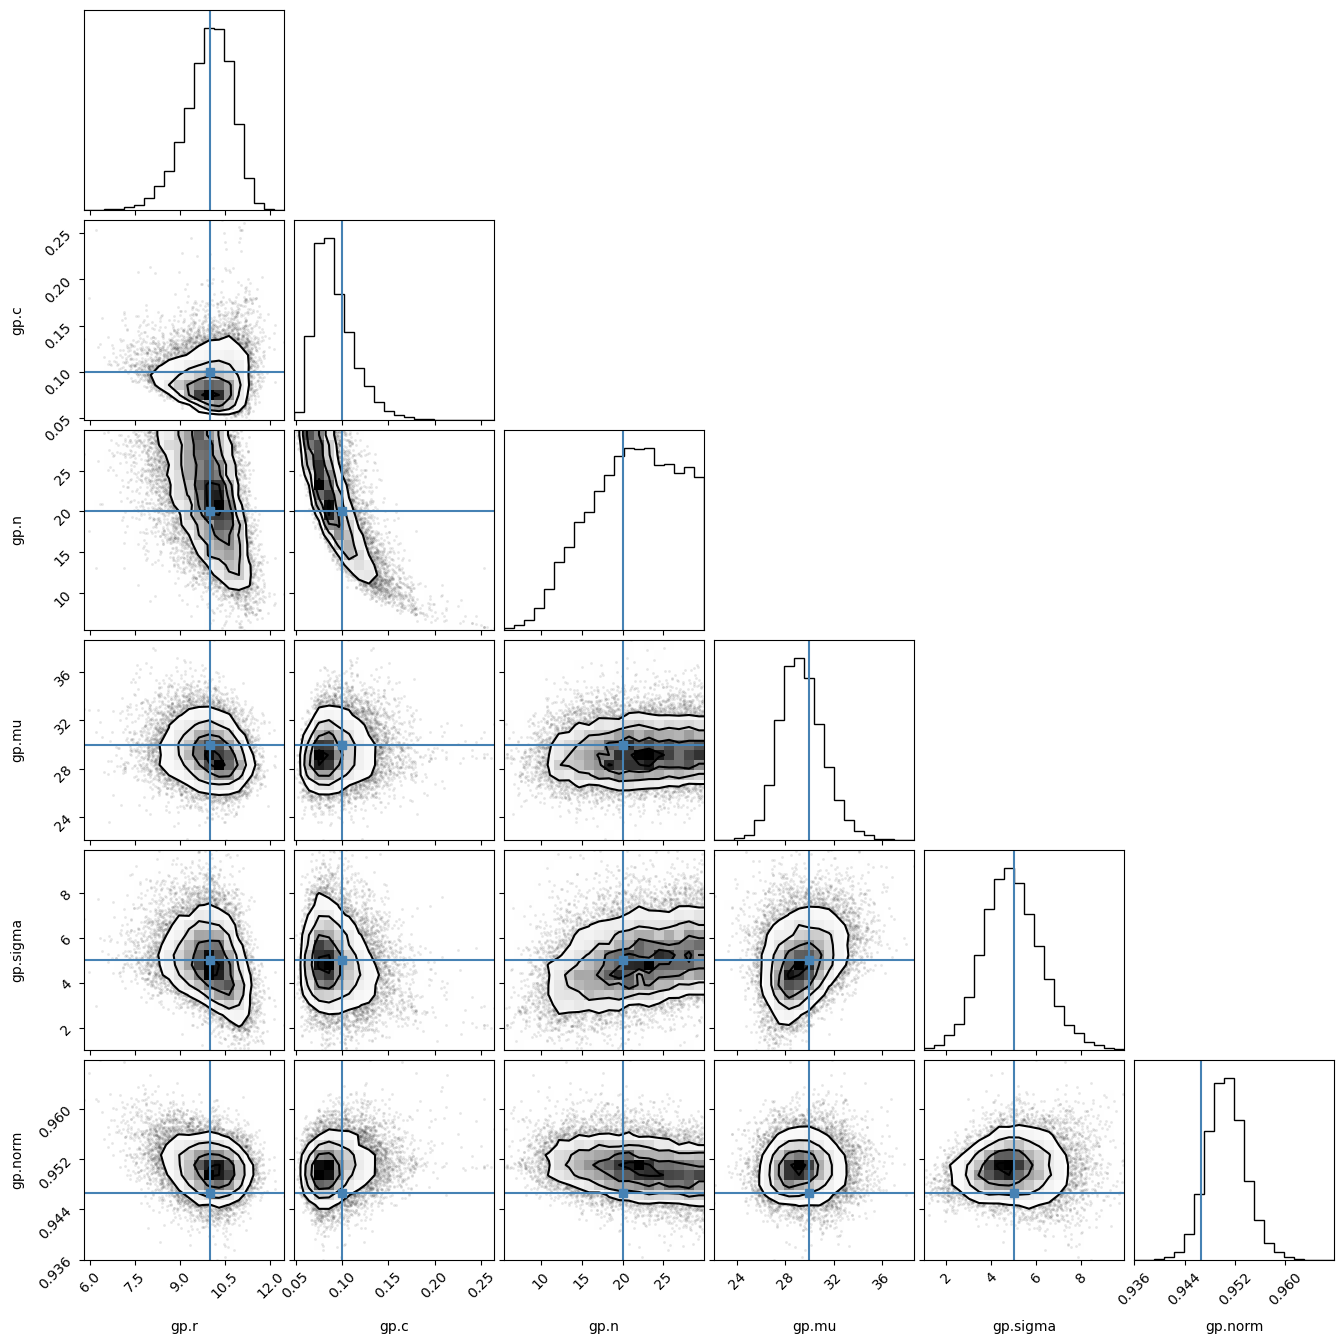

In [50]:
corner(np.array(samples), labels=free, truths=[params[x]["truth"] for x in free]);

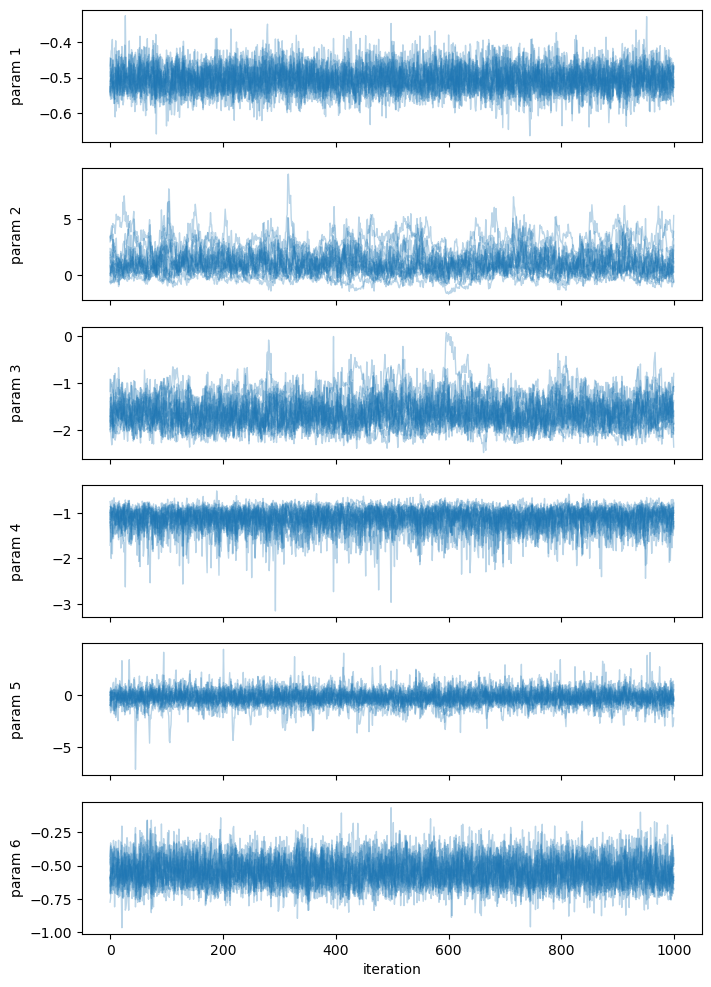

In [63]:
# Plot the walkers
fig, ax = plt.subplots(ndim, figsize=(8, 12), sharex=True)
for j in range(ndim):
    for k in range(nwalkers):
        ax[j].plot(sampler_new.chain[k, :, j], "C0-", lw=1, alpha=0.3)
    ax[j].set_ylabel("param {}".format(j + 1))
ax[-1].set_xlabel("iteration")
fig.align_ylabels(ax)
plt.show()

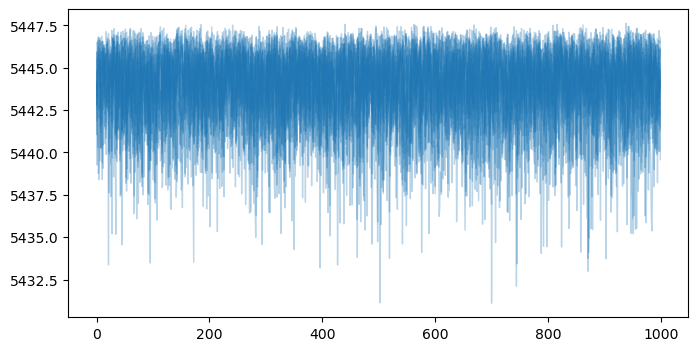

In [64]:
fig, ax = plt.subplots(1, figsize=(8, 4))
for k in range(nwalkers):
    plt.plot(sampler_new.lnprobability[k], "C0-", lw=1, alpha=0.3)

In [62]:
# az.from_pymc3(sampler_new);
az.to_netcdf(sampler_new,'sampler_64000_gps.nc');

In [65]:
az_trace = az.from_netcdf('sampler_64000_gps.nc')

array([[<AxesSubplot: title={'center': 'var_0'}>,
        <AxesSubplot: title={'center': 'var_0'}>],
       [<AxesSubplot: title={'center': 'var_1'}>,
        <AxesSubplot: title={'center': 'var_1'}>],
       [<AxesSubplot: title={'center': 'var_2'}>,
        <AxesSubplot: title={'center': 'var_2'}>],
       [<AxesSubplot: title={'center': 'var_3'}>,
        <AxesSubplot: title={'center': 'var_3'}>],
       [<AxesSubplot: title={'center': 'var_4'}>,
        <AxesSubplot: title={'center': 'var_4'}>],
       [<AxesSubplot: title={'center': 'var_5'}>,
        <AxesSubplot: title={'center': 'var_5'}>]], dtype=object)

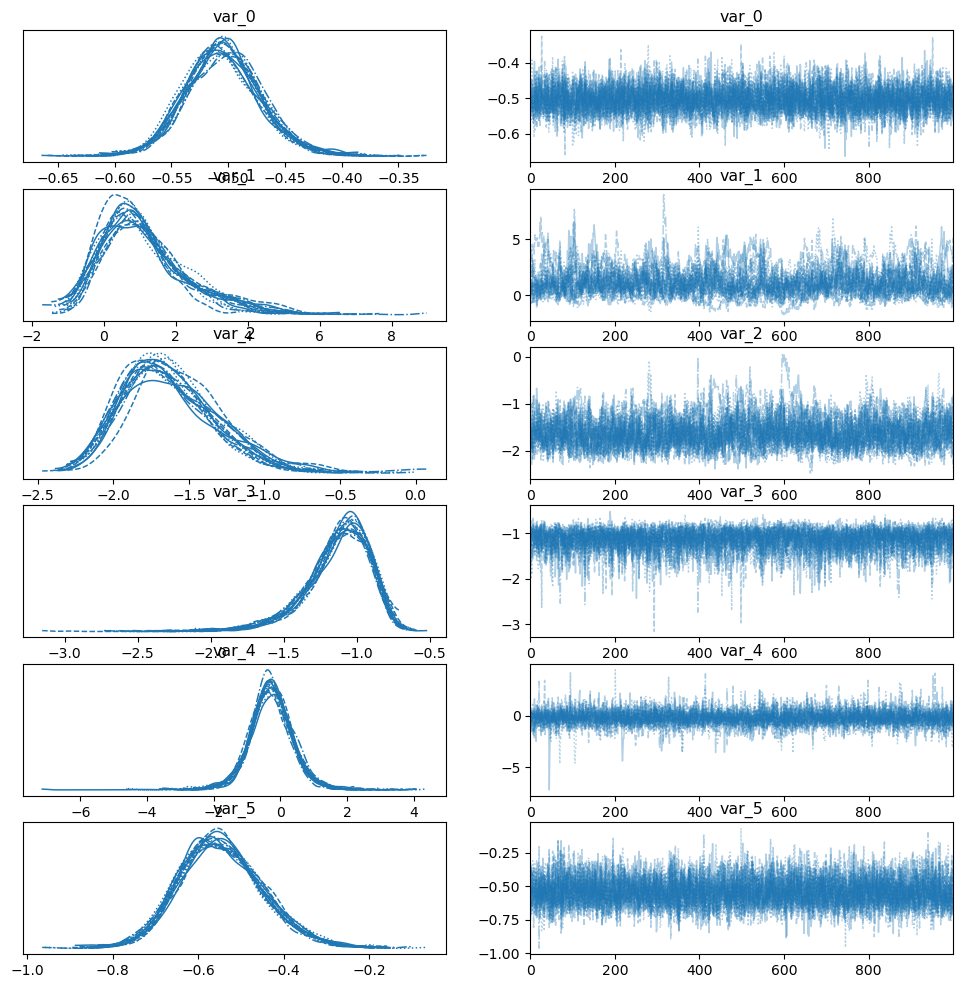

In [67]:
az.plot_trace(az_trace)

In [74]:
samples_fromfile = az_trace.to_dataframe()

In [82]:
samples_fromfile = samples_fromfile.iloc[:, 2:9]

In [86]:
samples_fromfile = samples_fromfile.iloc[:,:-1]

In [88]:
samples_fromfile = mci.transform(samples_fromfile, varnames=free)

100%|██████████| 15000/15000 [10:30<00:00, 23.80it/s]


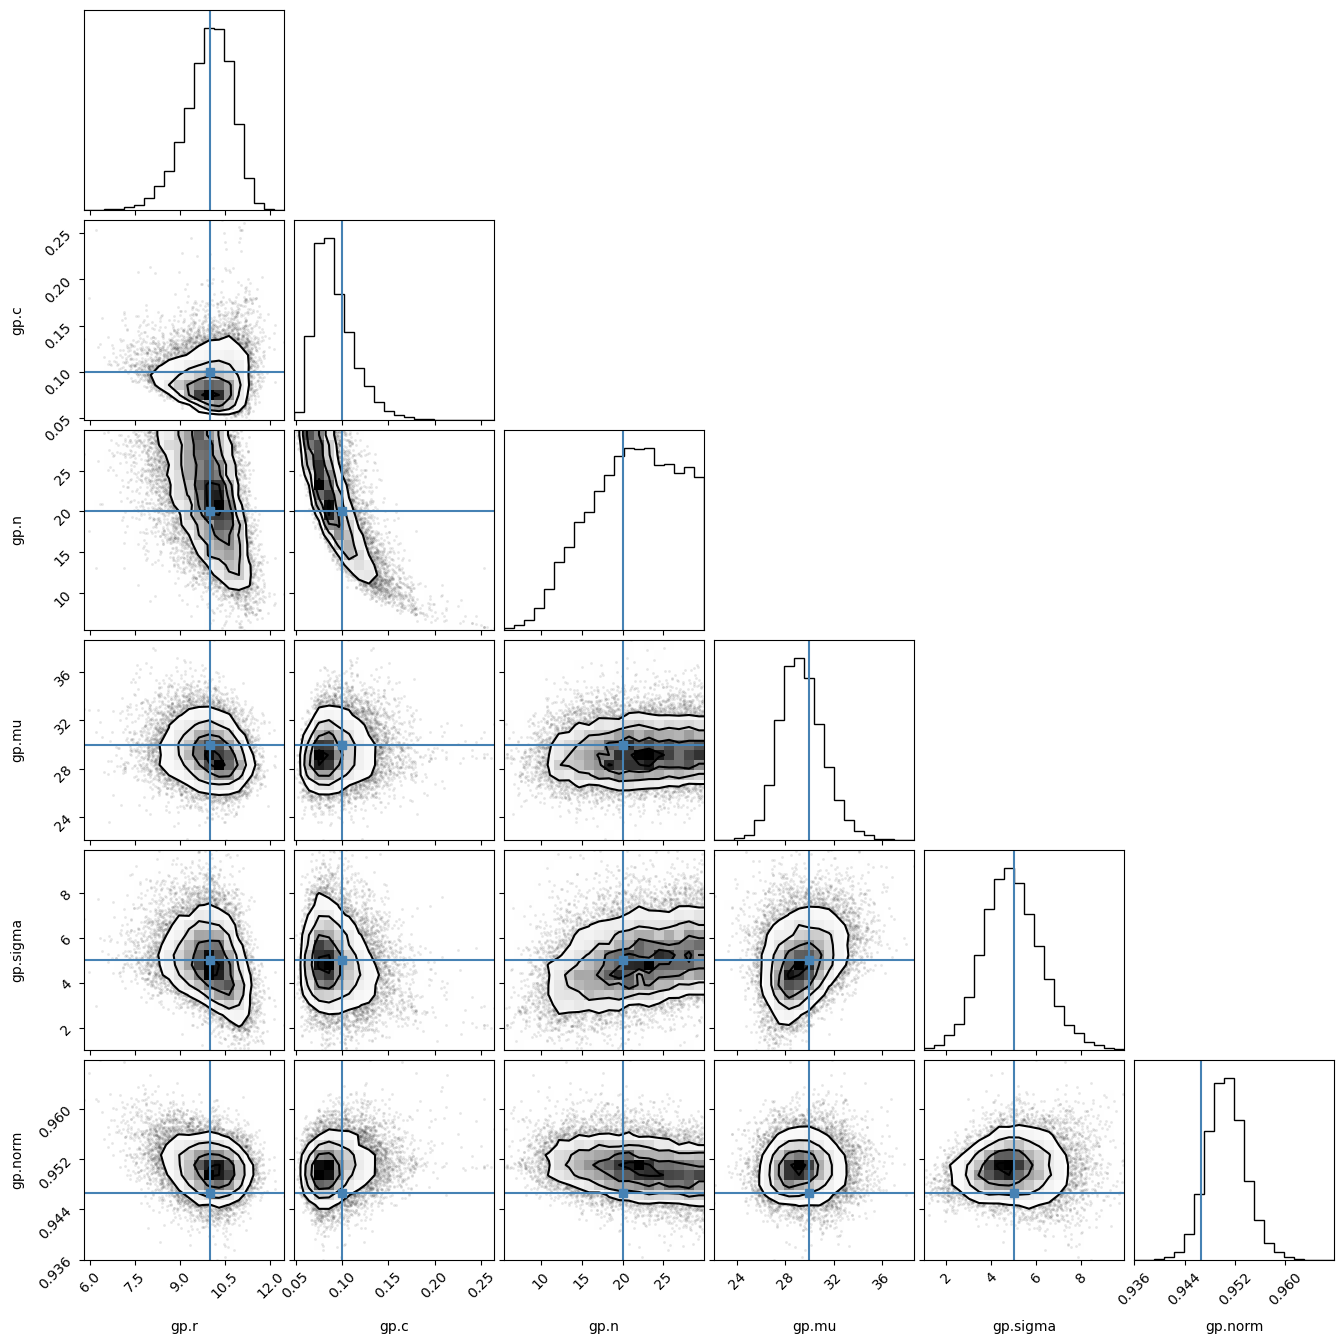

In [89]:
corner(np.array(samples_fromfile), labels=free, truths=[params[x]["truth"] for x in free]);

# NUTS

In [9]:
# Optimize
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")

optimizing logp for variables: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]



gp.r: 10.518506975867922 [10]
gp.c: 0.08690858601728312 [0.1]
gp.n: 18.94065165441344 [20]
gp.mu: 28.587074857529707 [30]
gp.sigma: 3.758255180547771 [5]
gp.norm: 0.9501552079362121 [0.9465594370762206]


message: Desired error not necessarily achieved due to precision loss.
logp: 5445.607563498468 -> 5447.713001188291


In [12]:
%%time
with model:
    trace = pm.sample(
        2000, tune=2000, start=map_soln, cores=1, target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 197546 seconds.
There were 164 divergences after tuning. Increase `target_accept` or reparameterize.
There were 631 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6223355240742444, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 8d 55min 1s, sys: 6d 11h 40min 27s, total: 14d 12h 35min 28s
Wall time: 2d 6h 52min 40s


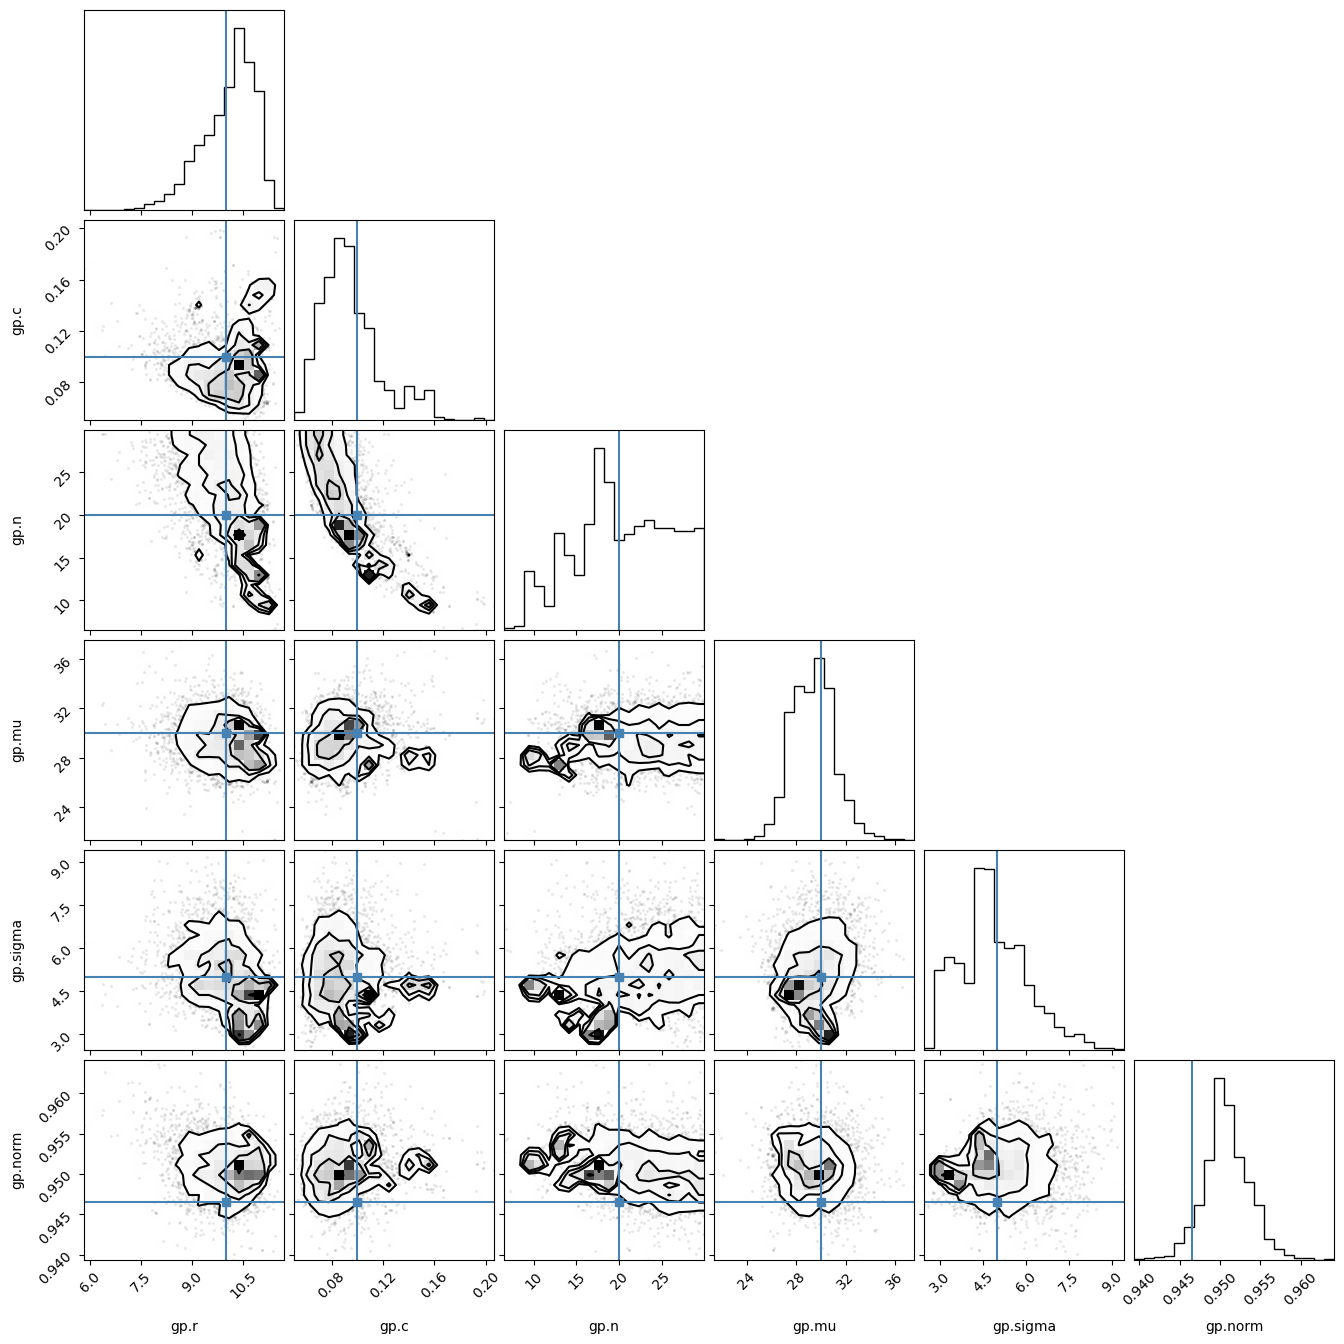

In [13]:
samples = pm.trace_to_dataframe(trace, varnames=free)
corner(np.array(samples), labels=free, truths=[params[x]["truth"] for x in free]);

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot: title={'center': 'gp.mu'}>,
        <AxesSubplot: title={'center': 'gp.mu'}>],
       [<AxesSubplot: title={'center': 'gp.sigma'}>,
        <AxesSubplot: title={'center': 'gp.sigma'}>],
       [<AxesSubplot: title={'center': 'gp.r'}>,
        <AxesSubplot: title={'center': 'gp.r'}>],
       [<AxesSubplot: title={'center': 'gp.c'}>,
        <AxesSubplot: title={'center': 'gp.c'}>],
       [<AxesSubplot: title={'center': 'gp.n'}>,
        <AxesSubplot: title={'center': 'gp.n'}>],
       [<AxesSubplot: title={'center': 'gp.norm'}>,
        <AxesSubplot: title={'center': 'gp.norm'}>]], dtype=object)

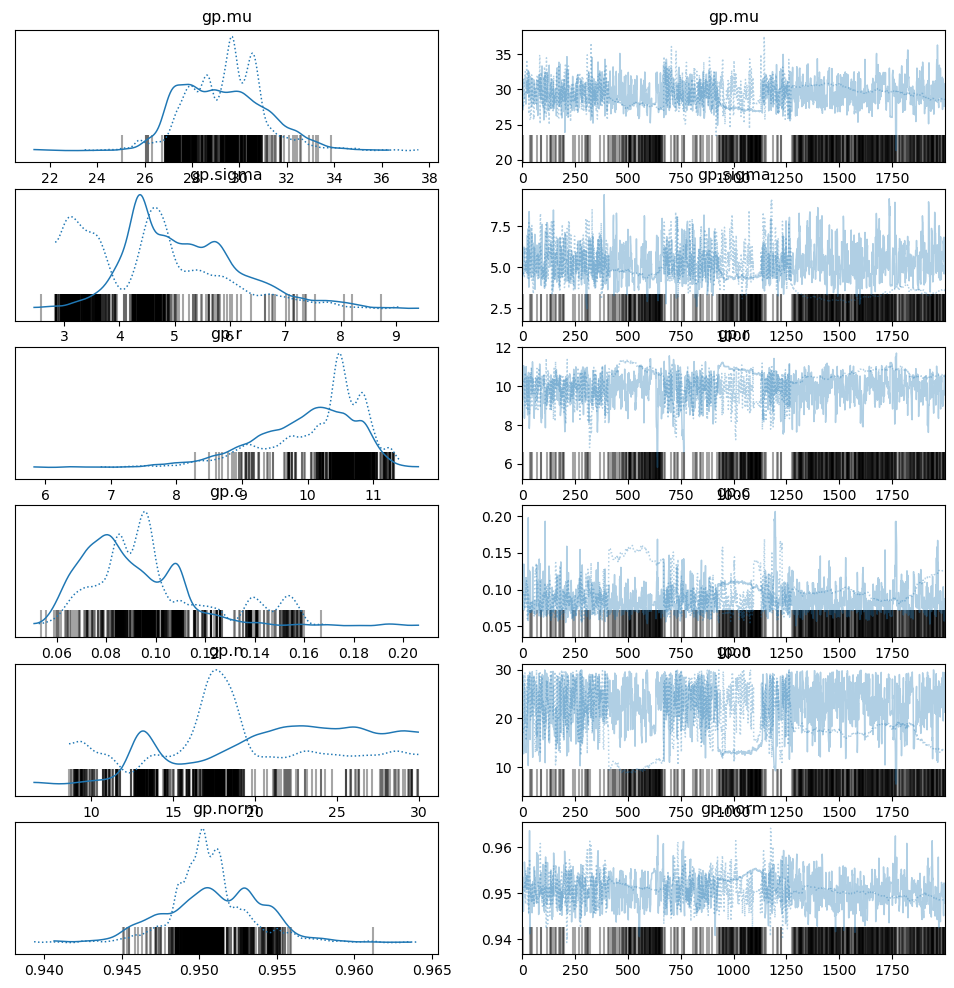

In [15]:
import arviz as az
az.plot_trace(trace)

In [18]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gp.mu,29.343,1.732,26.413,32.738,0.132,0.094,155.0,1275.0,1.05
gp.sigma,4.867,1.191,2.860,6.945,0.430,0.316,7.0,24.0,1.22
gp.r,10.059,0.775,8.661,11.314,0.102,0.075,48.0,85.0,1.02
gp.c,0.095,0.023,0.059,0.145,0.004,0.003,49.0,37.0,1.04
gp.n,20.369,5.554,11.072,29.982,0.913,0.651,39.0,25.0,1.04
gp.norm,0.951,0.003,0.945,0.956,0.000,0.000,155.0,744.0,1.05


In [19]:
az.to_netcdf(trace,'NUTS_gps_2000.nc');

Got error No model on context stack. trying to find log_likelihood in translation.


In [8]:
import pymc3.sampling_jax

RuntimeError: This version of jaxlib was built using AVX instructions, which your CPU and/or operating system do not support. You may be able work around this issue by building jaxlib from source.

In [23]:
%%time
# Inference button (TM)!
with model:
    trace_jax = pm.sampling_jax.sample_numpyro_nuts(2000, tune=2000, target_accept=0.9)

AttributeError: module 'jax.ops' has no attribute 'index_update'